TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

--- Análisis Automático ---
Saturación media del fondo: 0.03
Decisión: Fondo simple detectado. Usando Umbral de Otsu.
--------------------------
[INFO] Calibración completa. Escala: 8.20 px/mm


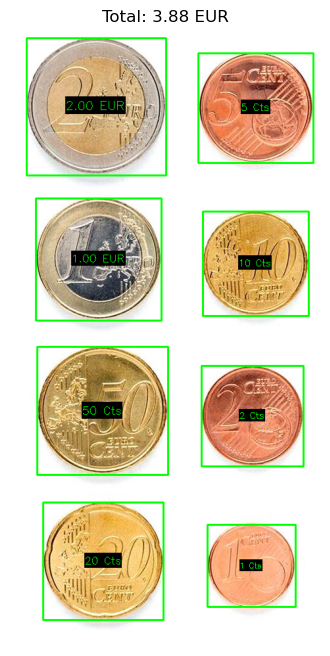

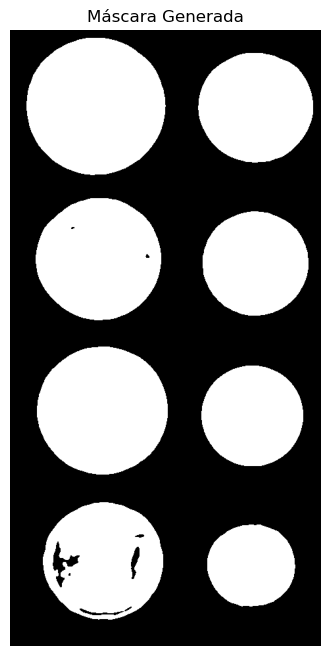

In [25]:
# --- LIBRERÍAS ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN INICIAL ---
nombre_archivo = 'Monedas.jpg'

# --- DATOS DE REFERENCIA ---
DATOS_MONEDAS = {
    "1 Céntimo": (16.25, 0.01), "2 Céntimos": (18.75, 0.02),
    "5 Céntimos": (21.25, 0.05), "10 Céntimos": (19.75, 0.10),
    "20 Céntimos": (22.25, 0.20), "50 Céntimos": (24.25, 0.50),
    "1 Euro": (23.25, 1.00), "2 Euros": (25.75, 2.00),
}
pixels_per_mm = None

# --- FUNCIONES AUXILIARES ---
def redimensionar_para_mostrar(imagen, ancho_max=1024):
    h, w = imagen.shape[:2]
    if w > ancho_max:
        ratio = ancho_max / float(w)
        return cv2.resize(imagen, (ancho_max, int(h * ratio)), interpolation=cv2.INTER_AREA)
    return imagen

def calibrar_escala(event, x, y, flags, param):
    global pixels_per_mm
    if event == cv2.EVENT_LBUTTONDOWN:
        contornos, ratio_redimension = param
        x_orig, y_orig = int(x / ratio_redimension), int(y / ratio_redimension)
        contorno_ref = min(contornos, key=lambda c: np.min(np.sum((c - [x_orig, y_orig])**2, axis=2)))
        (_, radio_px) = cv2.minEnclosingCircle(contorno_ref)
        diametro_px = radio_px * 2
        diametro_ref_mm = DATOS_MONEDAS["1 Euro"][0]
        pixels_per_mm = diametro_px / diametro_ref_mm
        print(f"[INFO] Calibración completa. Escala: {pixels_per_mm:.2f} px/mm")

# --- INICIO DEL PROCESAMIENTO PRINCIPAL ---
img_original = cv2.imread(nombre_archivo)

if img_original is None:
    print(f"Error: No se pudo cargar la imagen '{nombre_archivo}'.")
else:
    # --- ANÁLISIS AUTOMÁTICO DEL FONDO ---
    h, w = img_original.shape[:2]
    corner_size = int(min(h, w) * 0.1)
    corners = [
        img_original[0:corner_size, 0:corner_size],
        img_original[0:corner_size, w-corner_size:w],
        img_original[h-corner_size:h, 0:corner_size],
        img_original[h-corner_size:h, w-corner_size:w]
    ]
    border_pixels = np.vstack([c.reshape(-1, 3) for c in corners])
    hsv_border = cv2.cvtColor(np.uint8([border_pixels]), cv2.COLOR_BGR2HSV)
    avg_saturation = np.mean(hsv_border[0, :, 1])
    SATURATION_THRESHOLD = 25.0
    es_fondo_simple = avg_saturation < SATURATION_THRESHOLD

    print(f"--- Análisis Automático ---")
    print(f"Saturación media del fondo: {avg_saturation:.2f}")
    if es_fondo_simple:
        print("Decisión: Fondo simple detectado. Usando Umbral de Otsu.")
    else:
        print("Decisión: Fondo de color detectado. Usando Segmentación HSV.")
    print("--------------------------")

    # --- SELECCIÓN DEL MÉTODO DE SEGMENTACIÓN ---
    if es_fondo_simple:
        img_gris = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(img_gris, (15, 15), 0)
        _, mascara_limpia = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        img_blur = cv2.GaussianBlur(img_original, (11, 11), 0)
        img_hsv = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
        limite_bajo = np.array([0, 0, 0])
        limite_alto = np.array([91, 116, 255])
        mascara_final = cv2.inRange(img_hsv, limite_bajo, limite_alto)
        kernel = np.ones((7, 7), np.uint8)
        mascara_limpia = cv2.morphologyEx(mascara_final, cv2.MORPH_CLOSE, kernel, iterations=3)

    contornos, _ = cv2.findContours(mascara_limpia.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- FASE DE CALIBRACIÓN INTERACTIVA ---
    img_calibracion_display = redimensionar_para_mostrar(img_original, ancho_max=1024)
    ratio = img_calibracion_display.shape[1] / float(img_original.shape[1])
    img_calibracion_con_contornos = img_calibracion_display.copy()
    contornos_display = [(c * ratio).astype(int) for c in contornos]
    cv2.drawContours(img_calibracion_con_contornos, contornos_display, -1, (0, 255, 0), 2)
    
    cv2.namedWindow("Calibracion: Clic en la moneda de 1 Euro")
    cv2.setMouseCallback("Calibracion: Clic en la moneda de 1 Euro", calibrar_escala, param=(contornos, ratio))

    while pixels_per_mm is None:
        cv2.imshow("Calibracion: Clic en la moneda de 1 Euro", img_calibracion_con_contornos)
        if cv2.waitKey(1) & 0xFF == 27:
            break
    cv2.destroyAllWindows()

    # --- FASE DE CONTEO Y VISUALIZACIÓN ---
    if pixels_per_mm is not None:
        img_resultado = img_original.copy()
        total_valor = 0.0
        for c in contornos:
            area = cv2.contourArea(c)
            if area < 500: continue
            
            perimetro = cv2.arcLength(c, True)
            if perimetro == 0: continue
            circularidad = 4 * np.pi * (area / (perimetro**2))
            
            if 0.70 < circularidad < 1.30:
                (cx, cy), radio_px = cv2.minEnclosingCircle(c)
                diametro_mm = (radio_px * 2) / pixels_per_mm
                
                moneda_identificada = None
                min_diff = float('inf')
                for nombre, (diametro_real, valor) in DATOS_MONEDAS.items():
                    diff = abs(diametro_mm - diametro_real)
                    if diff < min_diff and diff < 2.0:
                        min_diff = diff
                        moneda_identificada = (nombre, valor)
                
                if moneda_identificada:
                    nombre_moneda, valor_moneda = moneda_identificada
                    total_valor += valor_moneda
                    etiqueta = f"{valor_moneda:.2f} EUR" if valor_moneda >= 1 else f"{int(valor_moneda*100)} Cts"
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(img_resultado, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    
                    font_escala = (radio_px * 2) / 350.0
                    font_grosor = max(1, int(font_escala * 2))
                    
                    (ancho_texto, alto_texto), baseline = cv2.getTextSize(etiqueta, cv2.FONT_HERSHEY_SIMPLEX, font_escala, font_grosor)

                    # --- CAMBIO EN LA POSICIÓN DE LA ETIQUETA ---
                    # Se calcula la posición para que el texto quede centrado en la moneda.
                    # El origen del texto (esquina inferior izquierda) se calcula a partir del centro (cx, cy).
                    pos_texto_x = int(cx - ancho_texto / 2)
                    pos_texto_y = int(cy + alto_texto / 2)
                    
                    # Se dibuja el fondo negro en la nueva posición centrada.
                    fondo_y1 = pos_texto_y - alto_texto - baseline
                    fondo_y2 = pos_texto_y + baseline
                    cv2.rectangle(img_resultado, (pos_texto_x, fondo_y1), (pos_texto_x + ancho_texto, fondo_y2), (0, 0, 0), -1)
                    
                    # Se escribe el texto de la etiqueta sobre el fondo.
                    cv2.putText(img_resultado, etiqueta, (pos_texto_x, pos_texto_y), cv2.FONT_HERSHEY_SIMPLEX, font_escala, (0, 255, 0), font_grosor)

        texto_total = f"Total: {total_valor:.2f} EUR"
        
        # 1. Crear y configurar la PRIMERA figura para la imagen de resultado
        plt.figure(figsize=(8, 8)) # Tamaño para la primera ventana
        plt.imshow(cv2.cvtColor(redimensionar_para_mostrar(img_resultado), cv2.COLOR_BGR2RGB))
        plt.title(texto_total)
        plt.axis('off')

        # 2. Crear y configurar la SEGUNDA figura para la máscara
        plt.figure(figsize=(8, 8)) # <-- ¡Esta línea crea la segunda ventana!
        plt.imshow(mascara_limpia, cmap='gray')
        plt.title('Máscara Generada')
        plt.axis('off')

        # 3. Mostrar TODAS las figuras creadas a la vez
        plt.show()


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y aprender patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test MPs_test.jpg y sus correpondientes anotaciones MPs_test_bbs.csv con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

<Figure size 800x800 with 0 Axes>

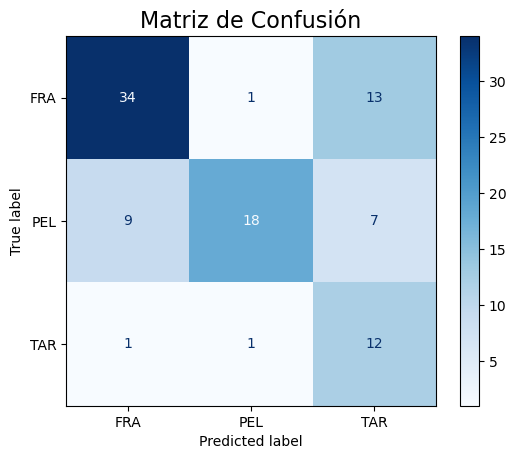


--- Resumen de Resultados ---
Total de partículas evaluadas: 96
Accuracy (Exactitud) General: 0.67

--- Métricas por Tipo de Partícula ---
              precision    recall  f1-score   support

         FRA       0.77      0.71      0.74        48
         PEL       0.90      0.53      0.67        34
         TAR       0.38      0.86      0.52        14

    accuracy                           0.67        96
   macro avg       0.68      0.70      0.64        96
weighted avg       0.76      0.67      0.68        96

------------------------------------


In [20]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# --- EXTRACCIÓN DE CARACTERÍSTICAS ---
# Toma la ruta de una imagen y extrae las características de las partículas que contiene
def get_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return []

    # aplica filtro clahe para mejorar el contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    blurred = cv2.GaussianBlur(img_clahe, (5, 5), 0) # elimina ruido
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 15, 2) # img binaria con umbrales diferentes
    kernel = np.ones((3,3), np.uint8)
    # operaciones morfológicas:
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1) # elimina ruido
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1) # rellena huecos
    
    # encuentra contornos en la máscara y recupera los exteriores
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features_list = [] # lista para las características de las partículas
    for cnt in contours:
        # itera sobre cada contorno y calcula su área
        area = cv2.contourArea(cnt)
        if area > 15:
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0: continue
            
            #  circularidad: indica qué tan cerca está la forma de ser un círculo perfecto
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            
            # obtiene rectángulo delimitador
            x, y, w, h = cv2.boundingRect(cnt)
            
            # calcula centro geométrico de la partícula usando los momentos de la img
            M = cv2.moments(cnt)
            # evita división por 0 si el momento es 0
            cX = int(M["m10"] / M["m00"]) if M["m00"] != 0 else x + w//2
            cY = int(M["m01"] / M["m00"]) if M["m00"] != 0 else y + h//2
            # almacena las características extraídas en diccionario
            features_list.append({
                "circularity": circularity,
                "centroid": (cX, cY),
                "bbox": (x, y, w, h)
            })
    return features_list

# --- ANÁLISIS DE DATOS DE ENTRENAMIENTO ---
# Analiza las imágenes de entrenamiento para aprender las propiedades de cada clase
def analizar_caracteristicas_entrenamiento(training_data):
    stats = {} # diccionario para allmacenar la circularidad media
    for label, image_path in training_data.items():
        # itera sobre cada clase y su imagen y extrae las características de esta
        particles = get_features(image_path)
        circularities = [p['circularity'] for p in particles]
        if circularities:
            # si se encuentran partículas, se calcula la circularidad media y la guarda
            stats[label] = {'mean_circularity': np.mean(circularities)}
    return stats

# --- CREACIÓN DEL CLASIFICADOR ---
# Crea y devuelve una función de clasificación basada en las estadísticas aprendidas
def crear_clasificador_dinamico(stats):
    # calcula un umbral(punto medio entre las circularidades) dinámico para separar FRA y TAR
    umbral_fra_tar = (stats['FRA']['mean_circularity'] + stats['TAR']['mean_circularity']) / 2
    
    def clasificar(particle_features):
        circularity = particle_features['circularity']
        if circularity > 0.85:
            # si la circularidad es muy alta (> 0.85), es un Pellet (PEL)
            return "PEL"
        elif circularity < umbral_fra_tar:
            # si es menor que el umbral dinámico, es un Fragmento (FRA)
            return "FRA"
        else:
            return "TAR"
            
    return clasificar

# --- EJECUCIÓN Y EVALUACIÓN ---
# Definir datos de entrenamiento
training_images = {"FRA": "FRA.png", "PEL": "PEL.png", "TAR": "TAR.png"}

# Aprender las estadísticas
estadisticas_entrenamiento = analizar_caracteristicas_entrenamiento(training_images)

# Crear el clasificador con umbrales dinámicos
clasificador_final = crear_clasificador_dinamico(estadisticas_entrenamiento)

# Extrae las características de todas las partículas en la imagen de test
test_particles = get_features('MPs_test.jpg')
# Lee el archivo CSV con las anotaciones manuales
annotations = pd.read_csv("MPs_test_bbs.csv")

# Listas para almacenar las etiquetas reales y las predichas por el modelo
y_true = []
y_pred = []
detected_and_classified_bboxes = [] # Almacenar bboxes y etiquetas predichas para dibujar

# Nombres de las clases ordenados por su circularidad media para una visualización consistente
class_names = sorted(training_images.keys(), key=lambda k: estadisticas_entrenamiento[k]['mean_circularity'])

# Colores para dibujar las clasificaciones
colors = {
    "FRA": (0, 0, 255),   # Rojo para Fragmentos
    "PEL": (0, 255, 0),   # Verde para Pellets
    "TAR": (255, 0, 0)    # Azul para Alquitrán
}

# Cargar la imagen original a color para dibujar sobre ella
image_with_detections = cv2.imread('MPs_test.jpg')

# Itera sobre cada anotación manual (cada partícula real)
for index, row in annotations.iterrows():
    # obtiene la etiqueta real y las coordenadas de la caja delimitadora de la anotación
    true_label = row['label']
    x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
    
    # busca la partícula detectada cuyo centroide cae dentro de la caja de la anotación
    best_match = None
    particles_copy = test_particles[:] 
    for particle in particles_copy:
        cx, cy = particle['centroid']
        # comprueba si el centroide de la partícula detectada está dentro de la caja de la anotación
        if x_min < cx < x_max and y_min < cy < y_max:
            # si hay coincidenccia, se guarda la partícula 
            best_match = particle
            test_particles.remove(particle) # se elimina de la lista para evitar múltiples anotaciones
            break
    
    if best_match:
        # si se detecta partícula que coincide con anotación 
        # se usa clasificador para predecir su clase
        predicted_label = clasificador_final(best_match)
        y_true.append(true_label) # etiqueta real
        y_pred.append(predicted_label) # etiqueta predicha
        
        detected_and_classified_bboxes.append({
            #'bounding box' (la caja delimitadora con coordenadas x, y, w, h)
            "bbox": best_match["bbox"],
            # etiqueta de clase (ej. "FRA", "PEL") que el clasificador 
            # acaba de asignar a esta partícula
            "predicted_label": predicted_label
        })

# Convertir de BGR a RGB para mostrar con matplotlib
image_with_detections_rgb = cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB)

# Mostrar Matriz de Confusión y plots
cm = confusion_matrix(y_true, y_pred, labels=class_names)

# --- GRÁFICO 2: MATRIZ DE CONFUSIÓN ---
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión', fontsize=16)

plt.show()

# --- SALIDAS DE TEXTO ---
print("\n--- Resumen de Resultados ---")
print(f"Total de partículas evaluadas: {len(y_true)}")

# Calcula y muestra las métricas si se evaluó al menos una partícula
if len(y_true) > 0:
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, labels=class_names)
    
    print(f"Accuracy (Exactitud) General: {accuracy:.2f}\n")
    print("--- Métricas por Tipo de Partícula ---")
    print(report)
    print("------------------------------------")

plt.show()